Aurora Precipitation ML Notebook

Problem: Unstable convergence

Ideas:
- [Works] Overfit to a single sample first
- Increase network size
  - Tried a 5 layer FF network, no improvement.
- Huber loss (https://pytorch.org/docs/stable/generated/torch.nn.HuberLoss.html)
  - I don't think this will improve model performance
- [Works] normalize (mean = 0, std dev = 1) all input features
- [Works] Scale output features (log scale?)
  - Applied log then followed by mean = 0, std dev = 1 on the log values
- Make the model output a gaussian distribution as opposed to a single node. Loss is GaussianNLL (https://pytorch.org/docs/stable/generated/torch.nn.GaussianNLLLoss.html)
  - This seems to work decently but I'm getting unstable training, have to debug this.
- Output multiple gaussian distributions (mixture density network)
- k-fold cross-validation
(By using multiple training and testing cycles, it minimizes the risk of overfitting to a particular data split)
- Look into ensemble of models with different initial conditions / handling of outliers
(model ensembles are used a lot in ATOC research since systems are so chaotic)

Things to do:
- Split out the test set into its own TSV so it stays constant every run.
(This wouldn't work with k-fold cross-validation)
- Add one cycle LR scheduling
- Filter the dataset according to Blake's suggestions
- Increase dataloder workers to num cpus
- Debug GaussianNetwork

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np

In [10]:
train_df = pd.read_csv('data/train.tsv', sep='\t')
eval_df = pd.read_csv('data/validation.tsv', sep='\t')
train_df = train_df.sample(frac=0.1).reset_index(drop=True)

In [11]:
# Keep only specific columns
columns_to_keep = ['Altitude', 'GCLAT', 'GCLON', 'ILAT', 'GLAT', 'GMLT', 'XXLAT', 'XXLON', 'Te1', 'Ne1', 'Pv1', 'I1', 'DateFormatted', 'TimeFormatted']
train_df = train_df[columns_to_keep]
eval_df = eval_df[columns_to_keep]

# Convert DateFormatted and TimeFormatted columns to datetime
train_df['DateFormatted'] = pd.to_datetime(train_df['DateFormatted'] + ' ' + train_df['TimeFormatted'], format='%Y-%m-%d %H:%M:%S')
eval_df['DateFormatted'] = pd.to_datetime(eval_df['DateFormatted'] + ' ' + eval_df['TimeFormatted'], format='%Y-%m-%d %H:%M:%S')
train_df.drop('TimeFormatted', axis=1, inplace=True)
eval_df.drop('TimeFormatted', axis=1, inplace=True)

train_df.head(3)

,Altitude,GCLAT,GCLON,ILAT,GLAT,GMLT,XXLAT,XXLON,Te1,Ne1,Pv1,I1,DateFormatted
0,1687.0,52.62,71.3,47.69,38.50,12.93,48.33,12.7,4274,1709,2.34,50,1997-06-03 07:59:06
1,3623.0,-25.61,136.0,35.21,-1.50,15.32,999.00,999.0,4545,2348,2.34,51,1996-06-10 06:11:04
2,3696.0,-56.81,10.0,55.17,-40.47,1.65,-54.46,1.5,3502,1451,2.19,49,1997-05-22 01:57:03


In [12]:
# Normalize all location and atmospheric parameters (mean = 0 and std dev = 1)
columns_to_normalize = ['Altitude', 'GCLAT', 'GCLON', 'ILAT', 'GLAT', 'GMLT', 'XXLAT', 'XXLON', 'Ne1', 'Pv1', 'I1', 'Te1']

# Function to calculate mean and std dev for specified columns
def calculate_stats(df, columns):
    means = df[columns].mean()
    stds = df[columns].std()
    return means, stds

# Function to normalize specified columns in the DataFrame
def normalize_df(df, means, stds, columns):
    df[columns] = (df[columns] - means) / stds
    return df

# Calculate mean and std for the specified columns
means, stds = calculate_stats(train_df, columns_to_normalize)
train_df_norm = normalize_df(train_df, means, stds, columns_to_normalize)

means, stds = calculate_stats(eval_df, columns_to_normalize)
eval_df_norm = normalize_df(eval_df, means, stds, columns_to_normalize)

# Verify there are no NaNs in the normalized DataFrame
assert train_df_norm[columns_to_normalize].isna().sum().sum() == 0, "NaN values found in normalized data"
assert eval_df_norm[columns_to_normalize].isna().sum().sum() == 0, "NaN values found in normalized data"

print("Normalized data shape:", train_df_norm.shape)
train_df_norm.head(3)

Normalized data shape: (420524, 13)


,Altitude,GCLAT,GCLON,ILAT,GLAT,GMLT,XXLAT,XXLON,Te1,Ne1,Pv1,I1,DateFormatted
0,-1.409704,0.684502,-0.831158,-0.149552,0.786159,0.197250,-0.002200,-0.169951,-0.625576,-0.130394,-0.115919,0.484468,1997-06-03 07:59:06
1,-0.650825,-0.910177,-0.222542,-0.350600,-0.317321,0.529998,5.409682,5.641005,-0.530749,-0.009025,-0.115919,0.538502,1996-06-10 06:11:04
2,-0.622210,-1.546173,-1.407791,-0.029052,-1.392386,-1.373207,-0.587353,-0.235937,-0.895709,-0.179398,-0.362060,0.430434,1997-05-22 01:57:03


In [13]:
# Convert date and time into cyclic features for both train and eval datasets
for df in [train_df_norm, eval_df_norm]:
    # Extract components from DateFormatted
    df['Year'] = df['DateFormatted'].dt.year - 1989
    df['DayOfYear'] = df['DateFormatted'].dt.dayofyear
    df['TimeOfDay'] = (df['DateFormatted'].dt.hour * 3600 +
                       df['DateFormatted'].dt.minute * 60 +
                       df['DateFormatted'].dt.second) / 86400

    # Calculate cyclic features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['TimeOfDay_sin'] = np.sin(2 * np.pi * df['TimeOfDay'])

# Drop original date column and intermediate columns
train_df_norm_final = train_df_norm.drop(['DateFormatted', 'DayOfYear', 'TimeOfDay'], axis=1)
eval_df_norm_final = eval_df_norm.drop(['DateFormatted', 'DayOfYear', 'TimeOfDay'], axis=1)

print("Cyclic features added to train and eval datasets.")
print("Train dataframe shape:", train_df_norm_final.shape)
print("Eval dataframe shape:", eval_df_norm_final.shape)
print("New columns in train dataset:", train_df_norm_final.columns.tolist())
print("New columns in eval dataset:", eval_df_norm_final.columns.tolist())



Cyclic features added to train and eval datasets.
Train dataframe shape: (420524, 15)
Eval dataframe shape: (100000, 15)
New columns in train dataset: ['Altitude', 'GCLAT', 'GCLON', 'ILAT', 'GLAT', 'GMLT', 'XXLAT', 'XXLON', 'Te1', 'Ne1', 'Pv1', 'I1', 'Year', 'DayOfYear_sin', 'TimeOfDay_sin']
New columns in eval dataset: ['Altitude', 'GCLAT', 'GCLON', 'ILAT', 'GLAT', 'GMLT', 'XXLAT', 'XXLON', 'Te1', 'Ne1', 'Pv1', 'I1', 'Year', 'DayOfYear_sin', 'TimeOfDay_sin']


In [14]:
input_columns = ['Altitude', 'GCLAT', 'GCLON', 'ILAT', 'GLAT', 'GMLT', 'XXLAT', 'XXLON', 'Ne1', 'Pv1', 'I1', 'Year', 'DayOfYear_sin', 'TimeOfDay_sin']
output_column = 'Te1'

class DataFrameDataset(Dataset):
    def __init__(self, dataframe, input_columns, output_column):
        self.X = torch.tensor(dataframe[input_columns].values, dtype=torch.float32)
        self.y = torch.tensor(dataframe[output_column].values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# class Network(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(Network, self).__init__()
#         self.layer1 = nn.Linear(input_size, hidden_size)
#         self.layer2 = nn.Linear(hidden_size, output_size)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.layer1(x))
#         x = self.layer2(x)
#         return x

class GaussianNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GaussianNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.mean_layer = nn.Linear(hidden_size, output_size)
        self.var_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.relu(self.layer1(x))
        mean = self.mean_layer(x)
        var = self.relu(self.var_layer(x))
        return mean, var

# Hyperparameters
batch_size = 8

# Set up data loader
train_ds = DataFrameDataset(train_df_norm_final, input_columns, output_column)
eval_ds = DataFrameDataset(eval_df_norm_final, input_columns, output_column)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
eval_loader = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=0)

# Initialize the model
input_size = len(input_columns)
hidden_size = 64
output_size = 1
# model = Network(input_size, hidden_size, output_size).to("cuda")
model = GaussianNetwork(input_size, hidden_size, output_size).to("cuda")

# Define loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.GaussianNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [15]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in tqdm(data_loader):
            x = x.to("cuda")
            y = y.to("cuda")
            # outputs = model(x)
            # loss = criterion(outputs, y)
            mean, var = model(x)
            loss = criterion(mean, y, var)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Training loop
num_epochs = 30
eval_every = 1
print_every = 1000

total_steps = 0
for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for x, y in tqdm(train_loader):
        x = x.to("cuda")
        y = y.to("cuda")

        # Forward pass
        mean, var = model(x)
        loss = criterion(mean, y, var)

        # TODO: Investigate why loss is negative

        if print_every is not None and (total_steps % print_every == 0 or total_steps == 0):
            print(f'Step [{total_steps}], Train Loss: {loss.item():.4f}')

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        total_steps += 1

    if (epoch + 1) % eval_every == 0:
        test_loss = evaluate_model(model, test_loader, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Avg Train Loss: {epoch_loss/len(train_loader):.4f}, Test Loss: {test_loss:.4f}')


print('Training finished!')

# Save the model
torch.save(model.state_dict(), 'simple_ff_model.pth')

# Final evaluation
final_test_loss = evaluate_model(model, test_loader, criterion)
print(f'Final Test MSE: {final_test_loss:.4f}')

  0%|          | 44/52566 [00:00<04:15, 205.24it/s]

Step [0], Train Loss: 408821.1250


  2%|▏         | 1072/52566 [00:02<02:01, 425.02it/s]

Step [1000], Train Loss: 53714.6680


  4%|▍         | 2087/52566 [00:04<01:48, 465.80it/s]

Step [2000], Train Loss: 0.0778


  6%|▌         | 3067/52566 [00:07<01:50, 448.58it/s]

Step [3000], Train Loss: -0.1187


  8%|▊         | 4092/52566 [00:09<01:44, 462.54it/s]

Step [4000], Train Loss: 0.4316


 10%|▉         | 5045/52566 [00:11<01:41, 470.16it/s]

Step [5000], Train Loss: -0.0562


 12%|█▏        | 6070/52566 [00:13<01:40, 460.37it/s]

Step [6000], Train Loss: -0.0344


 13%|█▎        | 7068/52566 [00:15<01:40, 451.36it/s]

Step [7000], Train Loss: 0.1463


 15%|█▌        | 8080/52566 [00:18<01:43, 431.63it/s]

Step [8000], Train Loss: -0.1321


 17%|█▋        | 9064/52566 [00:20<01:32, 468.47it/s]

Step [9000], Train Loss: 0.8534


 19%|█▉        | 10047/52566 [00:22<01:37, 434.79it/s]

Step [10000], Train Loss: 0.1093


 21%|██        | 10817/52566 [00:24<01:33, 446.27it/s]


KeyboardInterrupt: 

In [8]:
# Inference code

# TODO: Create a benchmark (percentage accuracy) to validate model is not overfitting
inference_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def unnormalize_target(pred, target_mean, target_std):
    pred = np.exp(pred * target_std + target_mean)
    return pred


with torch.no_grad():
    for idx, (x, y) in enumerate(inference_loader):
        x = x.to("cuda")
        y = y.to("cuda")
        # print("x:", x)
        print("y:", unnormalize_target(y.item(), target_mean, target_std))
        mean, var = model(x)
        print("Prediction", unnormalize_target(mean.item(), target_mean, target_std))
        if idx > 4:
            break

y: 7424.000062457462
Prediction 4366.337213231267
y: 4553.000006766773
Prediction 7920.859834885141
y: 5507.999999886252
Prediction 5091.6168122874815
y: 7440.000091077357
Prediction 9133.70495691905
y: 4809.999999881303
Prediction 3826.4774407709324
y: 4809.999999881303
Prediction 6629.711670381693


In [9]:
# Suppose that within +-10% of actual value is a sucess

# TODO: Plot the loss to visualize overfitting
# TODO: Save each model to Google Drive for benchmarking later
# TODO: Create a polar visualization in order to compare each model to the next one
# TODO: Creat metrics to compare each model to the next one
# TODO: Remove normalization and compare to normalized model

Epoch [1/30], Avg Train Loss: 0.4040, Test Loss: 0.1765


Epoch [2/30], Avg Train Loss: 0.5770, Test Loss: 0.0990


Epoch [3/30], Avg Train Loss: 0.8843, Test Loss: 0.0427


Epoch [4/30], Avg Train Loss: 0.2812, Test Loss: 0.0085


Epoch [5/30], Avg Train Loss: 0.2589, Test Loss: -0.0139


Epoch [6/30], Avg Train Loss: 0.2444, Test Loss: -0.0356


Epoch [7/30], Avg Train Loss: 0.2865, Test Loss: -0.0415


Epoch [8/30], Avg Train Loss: 0.5262, Test Loss: -0.0642


Epoch [9/30], Avg Train Loss: 0.2058, Test Loss: -0.0772


Epoch [10/30], Avg Train Loss: 0.1906, Test Loss: -0.0902


Epoch [11/30], Avg Train Loss: 0.2368, Test Loss: -0.0833


Epoch [12/30], Avg Train Loss: 0.2752, Test Loss: -0.0973


Epoch [13/30], Avg Train Loss: 0.1495, Test Loss: -0.1232


Epoch [14/30], Avg Train Loss: 0.1182, Test Loss: -0.1232


Epoch [15/30], Avg Train Loss: 0.4029, Test Loss: -0.1190


Epoch [16/30], Avg Train Loss: 0.2002, Test Loss: -0.1482


Epoch [17/30], Avg Train Loss: 0.1518, Test Loss: -0.1395


Epoch [18/30], Avg Train Loss: 0.2024, Test Loss: -0.1566


Epoch [19/30], Avg Train Loss: 0.1048, Test Loss: -0.1584


Epoch [20/30], Avg Train Loss: 0.1146, Test Loss: -0.1705


Epoch [21/30], Avg Train Loss: 0.1021, Test Loss: -0.1773


Epoch [22/30], Avg Train Loss: 0.0907, Test Loss: -0.1634


Epoch [23/30], Avg Train Loss: 0.0362, Test Loss: -0.1831


Epoch [24/30], Avg Train Loss: 0.1133, Test Loss: -0.1938


Epoch [25/30], Avg Train Loss: 0.0365, Test Loss: -0.2039


Epoch [26/30], Avg Train Loss: 0.0173, Test Loss: -0.2039


Epoch [27/30], Avg Train Loss: 0.1619, Test Loss: -0.2271


Epoch [28/30], Avg Train Loss: 0.0940, Test Loss: -0.2116


Epoch [29/30], Avg Train Loss: 0.0660, Test Loss: -0.2239


Epoch [30/30], Avg Train Loss: 0.0424, Test Loss: -0.2292
Training finished!


Final Test MSE: -0.2292


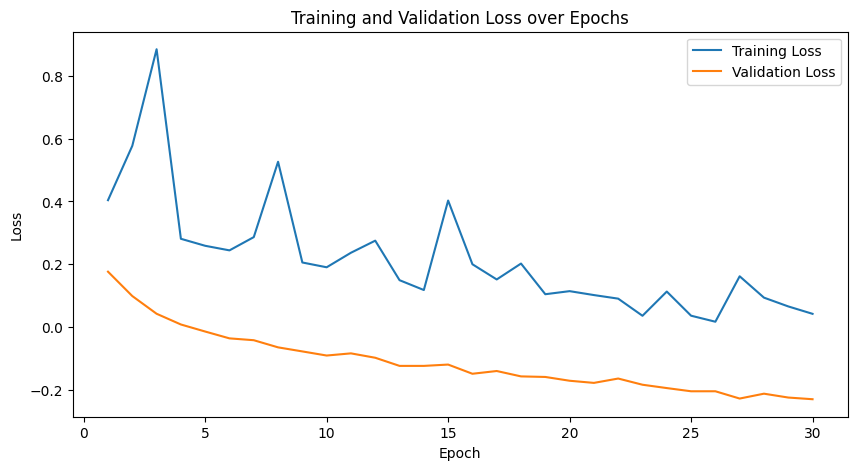

In [11]:
# Updated Model Architecture

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assuming df_normalized, input_columns, and output_column are defined

class DataFrameDataset(Dataset):
    def __init__(self, dataframe, input_columns, output_column):
        self.X = torch.tensor(dataframe[input_columns].values, dtype=torch.float32)
        self.y = torch.tensor(dataframe[output_column].values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ImprovedGaussianNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(ImprovedGaussianNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)  # Additional hidden layer
        self.mean_layer = nn.Linear(hidden_size, output_size)
        self.var_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        mean = self.mean_layer(x)
        var = self.softplus(self.var_layer(x)) + 1e-6  # Add epsilon to prevent zero variance
        return mean, var

# Hyperparameters
batch_size = 8
input_size = len(input_columns)
hidden_size = 128  # Increased hidden size
output_size = 1
num_epochs = 30
learning_rate = 3e-4
weight_decay = 1e-5  # L2 regularization parameter
clip_value = 1.0  # For gradient clipping
dropout_prob = 0.5  # Dropout probability

# Set up data loader
dataset = DataFrameDataset(df_normalized, input_columns, output_column)

# Split the dataset into train and test sets
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Initialize the model
model = ImprovedGaussianNetwork(input_size, hidden_size, output_size, dropout_prob=dropout_prob).to("cuda")

# Define loss function and optimizer
criterion = nn.GaussianNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in tqdm(data_loader, leave=False):
            x = x.to("cuda")
            y = y.to("cuda")
            mean, var = model(x)
            loss = criterion(mean, y, var)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Training loop
train_losses = []
val_losses = []
total_steps = 0
for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for x, y in tqdm(train_loader, leave=False):
        x = x.to("cuda")
        y = y.to("cuda")

        # Forward pass
        mean, var = model(x)
        loss = criterion(mean, y, var)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

        epoch_loss += loss.item()
        total_steps += 1

    # Evaluate on test set
    test_loss = evaluate_model(model, test_loader, criterion)
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(test_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Avg Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}')

print('Training finished!')

# Save the model
torch.save(model.state_dict(), 'improved_gaussian_model_with_dropout.pth')

# Final evaluation
final_test_loss = evaluate_model(model, test_loader, criterion)
print(f'Final Test MSE: {final_test_loss:.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


In [1]:
# Updated Model Architecture with Hyperparameter Tuning Using Optuna

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import optuna

# Assuming df_normalized, input_columns, and output_column are defined

class DataFrameDataset(Dataset):
    def __init__(self, dataframe, input_columns, output_column):
        self.X = torch.tensor(dataframe[input_columns].values, dtype=torch.float32)
        self.y = torch.tensor(dataframe[output_column].values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ImprovedGaussianNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_prob=0.5, activation='relu'):
        super(ImprovedGaussianNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU())
        elif activation == 'elu':
            layers.append(nn.ELU())
        layers.append(nn.Dropout(p=dropout_prob))
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leakyrelu':
                layers.append(nn.LeakyReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())
            layers.append(nn.Dropout(p=dropout_prob))
        self.hidden_layers = nn.Sequential(*layers)
        self.mean_layer = nn.Linear(hidden_size, output_size)
        self.var_layer = nn.Linear(hidden_size, output_size)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.hidden_layers(x)
        mean = self.mean_layer(x)
        var = self.softplus(self.var_layer(x)) + 1e-6  # Prevent zero variance
        return mean, var

def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    dropout_prob = trial.suggest_uniform('dropout_prob', 0.1, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    num_layers = trial.suggest_int('num_layers', 1, 4)
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu'])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Set up the dataset
    dataset = DataFrameDataset(df_normalized, input_columns, output_column)
    dataset_size = len(dataset)
    n_splits = 5  # Number of folds for cross-validation
    fold_size = dataset_size // n_splits
    indices = np.arange(dataset_size)

    fold_mses = []
    fold_r2s = []

    for fold in range(n_splits):
        # Time series split
        val_start = fold * fold_size
        val_end = val_start + fold_size
        train_indices = indices[:val_end]
        val_indices = indices[val_end:val_end + fold_size] if val_end + fold_size <= dataset_size else indices[val_end:]

        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize the model
        model = ImprovedGaussianNetwork(len(input_columns), hidden_size, 1, num_layers=num_layers, dropout_prob=dropout_prob, activation=activation).to(device)

        # Define loss function, optimizer, and scheduler
        criterion = nn.GaussianNLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=False)

        # Early stopping variables
        best_val_loss = float('inf')
        epochs_no_improve = 0
        patience = 10  # Early stopping patience
        num_epochs = 50  # Reduced for faster trials

        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0
            for x, y in train_loader:
                x = x.to(device)
                y = y.to(device)

                # Forward pass
                mean, var = model(x)
                loss = criterion(mean, y, var)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)

            # Validation
            model.eval()
            total_val_loss = 0
            preds = []
            trues = []
            with torch.no_grad():
                for x, y in val_loader:
                    x = x.to(device)
                    y = y.to(device)
                    mean, var = model(x)
                    loss = criterion(mean, y, var)
                    total_val_loss += loss.item()
                    preds.extend(mean.cpu().numpy())
                    trues.extend(y.cpu().numpy())
            avg_val_loss = total_val_loss / len(val_loader)
            mse = mean_squared_error(trues, preds)
            r2 = r2_score(trues, preds)

            # Scheduler step
            scheduler.step(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    break

        # Record metrics for the fold
        fold_mses.append(mse)
        fold_r2s.append(r2)

    # Return the average MSE across folds
    avg_mse = np.mean(fold_mses)
    return avg_mse

# Create a study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)

# Train final model with best hyperparameters
best_params = study.best_params
lr = best_params['lr']
hidden_size = best_params['hidden_size']
dropout_prob = best_params['dropout_prob']
weight_decay = best_params['weight_decay']
batch_size = best_params['batch_size']
num_layers = best_params['num_layers']
activation = best_params['activation']

# You can now train your final model using these hyperparameters
# and evaluate its performance


KeyboardInterrupt: 